# Exploratory Data Analysis on PWM Behavioral Data

**Goal** This notebook will explore the features that predict time to train (TTT) and final hit rate.

Related notebooks:
* EDA_01_describe_perf.ipynb
* create_trained_threshold_df.ipynb

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data import ANIMAL_IDS
from multiglm.models.linear_regression import *

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

choice_palette = sns.color_palette("Set2", 3)

## Load In

In [3]:
full_df = (
    DatasetLoader(
        animal_ids=ANIMAL_IDS,
        data_type="new_all",
    )
    .load_data()
    .query("animal_id ! = 'W082'")
)


trained_thresholds = pd.read_csv(
    "../data/processed/dataset_thresholding/threshold_sessions.csv"
)


def get_data_pre_trained(group):
    trained_session = trained_thresholds.query(
        "animal_id == @group.name"
    ).hit_threshold.values[0]

    return group.query("session < @trained_session")


pre_trained_df = (
    full_df.groupby("animal_id")
    .apply(get_data_pre_trained)
    .reset_index(drop=True)
    .copy()
)

# trained_df = DatasetLoader(
#     animal_ids=ANIMAL_IDS,
#     data_type="new_trained",
# ).load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Time to Train

### Features

In [10]:
# animal id and time to train
data = (
    trained_thresholds[["animal_id", "hit_threshold"]]
    .rename(columns={"hit_threshold": "trained_session"})
    .query("animal_id != 'W082'")
)

# number of delays
data["n_delays"] = data["animal_id"].map(
    pre_trained_df.query("training_stage >= 3")
    .groupby("animal_id")
    .delay_time.nunique()
)

# number of rigs
data["n_rigs"] = data["animal_id"].map(
    pre_trained_df.groupby("animal_id").rig_id.nunique()
)

# motor (stage 1) violations & hits
# data["motor_violations"] = data["animal_id"].map(
#     pre_trained_df.query("training_stage == 1")
#     .groupby(["animal_id", "session"])
#     .violation.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .violation.mean()
# )

# data["motor_hits"] = data["animal_id"].map(
#     pre_trained_df.query("training_stage == 1")
#     .groupby(["animal_id", "session"])
#     .hit.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .hit.mean()
# )

# guided rule (stage 3) hits (violations highly correlated w/ stage 4 )
# data["guided_rule_hits"] = data["animal_id"].map(
#     pre_trained_df.query("training_stage == 3")
#     .groupby(["animal_id", "session"])
#     .hit.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .hit.mean()
# )

# rule violations (hits would be too circular since it was used to determine threshold)
data["rule_learning_violations"] = data["animal_id"].map(
    pre_trained_df.query("training_stage == 3")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

data["early_stages_hits"] = data["animal_id"].map(
    pre_trained_df.query("training_stage <=3")
    .groupby(["animal_id", "session"])
    .hit.mean()
    .reset_index()
    .groupby("animal_id")
    .hit.mean()
)

# trial not started
# data["avg_n_trial_not_started"] = data["animal_id"].map(
#     pre_trained_df.groupby(["animal_id", "session"])
#     .n_prev_trial_not_started.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .n_prev_trial_not_started.mean()
# )

data.head()

,animal_id,trained_session,n_delays,n_rigs,rule_learning_violations,early_stages_hits
0,W051,325,5,5,0.273946,0.797285
1,W060,247,3,6,0.301450,0.858916
2,W065,100,3,1,0.343075,0.805420
3,W066,285,5,4,0.533096,0.795988
4,W068,422,3,3,0.384869,0.738468


<Axes: >

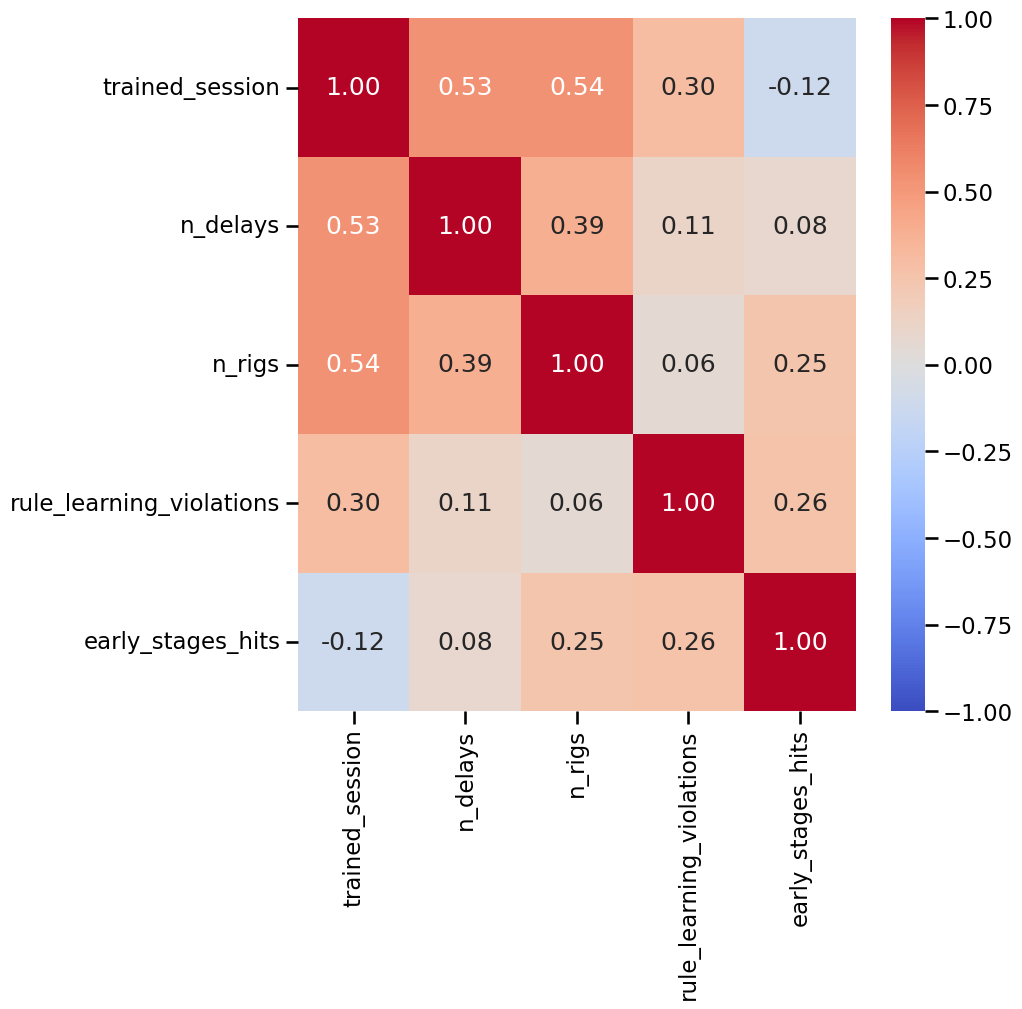

In [5]:
data_corr = data.query("animal_id != 'W082'").drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

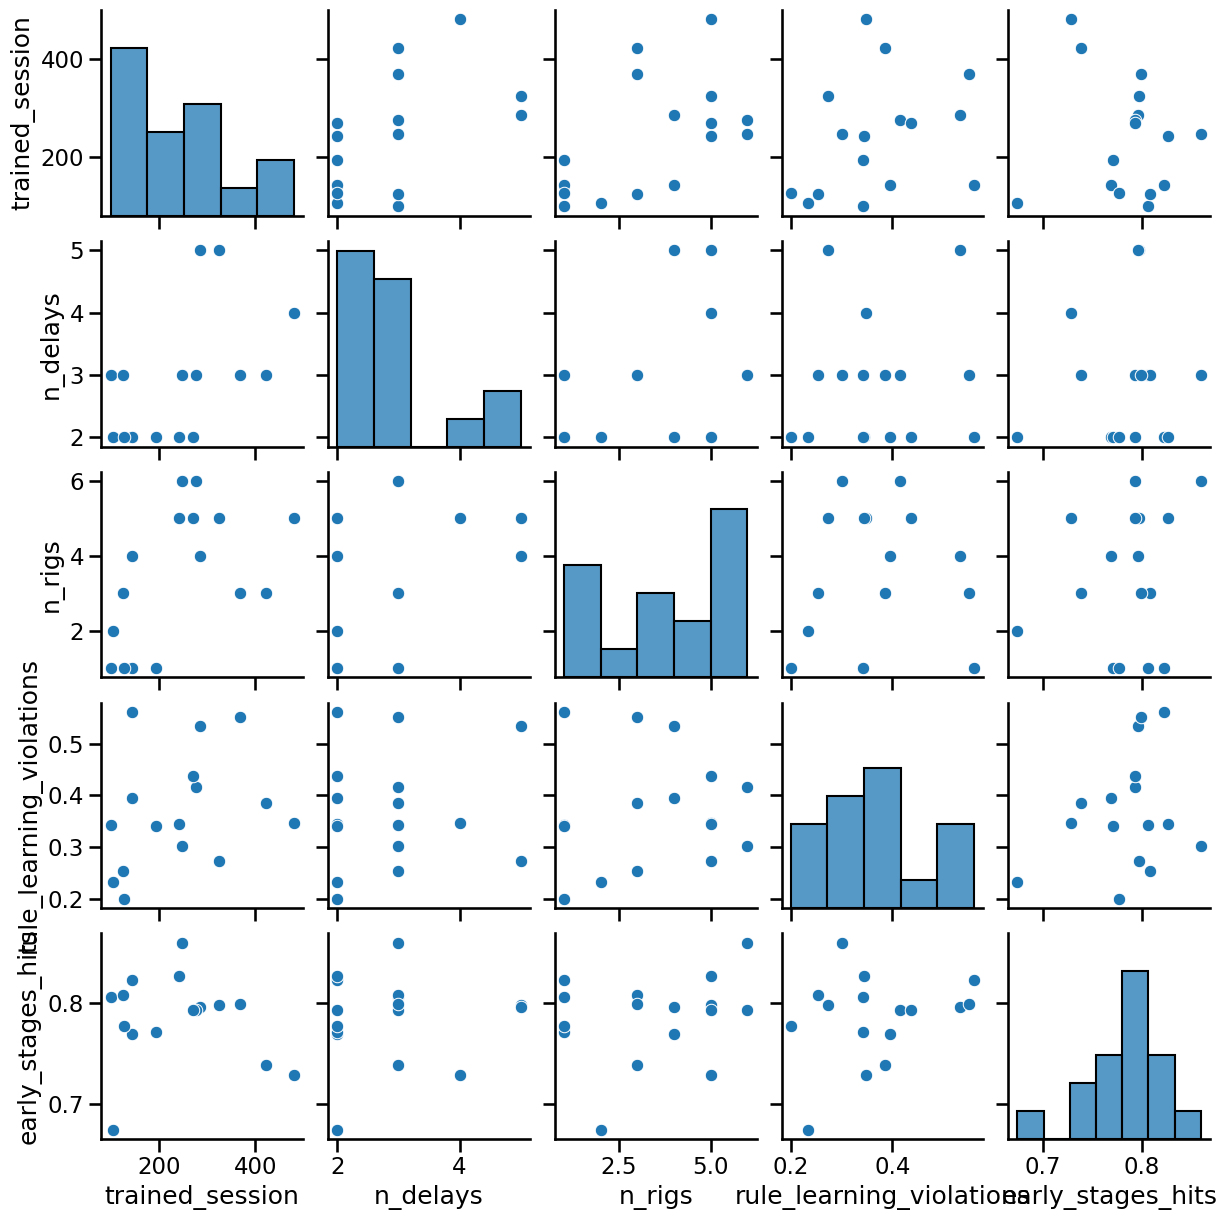

In [11]:
sns.pairplot(data)

### Predict

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


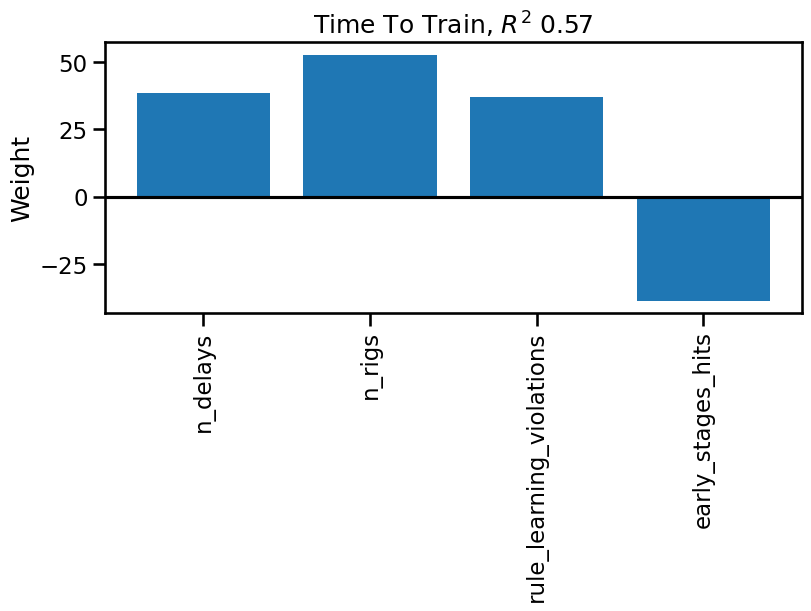

In [12]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_session"]
]

predictor = "trained_session"

model, predict, rsq, rns, ws = fit_linear_model(
    data, predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
plot_weights(ax, rns, ws, f"Time To Train, $R^2$ {rsq:.2f}")
# plt.ylim(-0.05, 0.05)

Pretty crazy to see the model double in performance when W082 is removed. This animal moved rigs 10 times! And seems to be quite the outlier. Perhaps this animal should be removed from the dataset given these abnormalities?

<Axes: xlabel='n_rigs', ylabel='trained_session'>

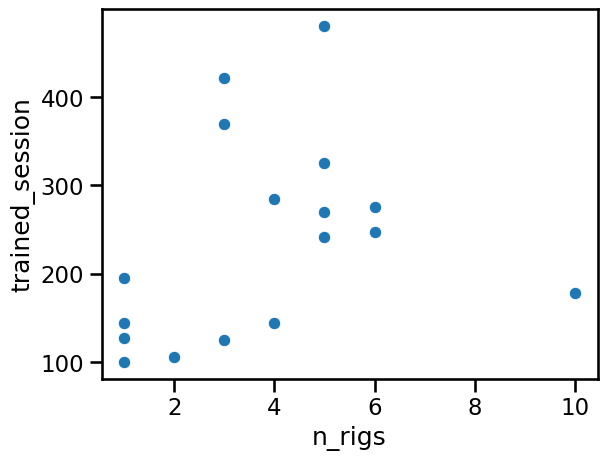

In [44]:
sns.scatterplot(data=data, x="n_rigs", y="trained_session")

## Final Hit Rate

In [22]:
data = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
)


# number of delays
data["n_delays"] = data["animal_id"].map(
    full_df.query("training_stage >=3").groupby("animal_id").delay_time.nunique()
)

# number of rigs
# data["n_rigs"] = data["animal_id"].map(full_df.groupby("animal_id").rig_id.nunique())

# motor (stage 1) violations & hits
data["motor_violations"] = data["animal_id"].map(
    pre_trained_df.query("training_stage == 1")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

data["motor_hits"] = data["animal_id"].map(
    pre_trained_df.query("training_stage == 1")
    .groupby(["animal_id", "session"])
    .hit.mean()
    .reset_index()
    .groupby("animal_id")
    .hit.mean()
)

# guided rule (stage 3) violations & hits
# data["guided_rule_hits"] = data["animal_id"].map(
#     pre_trained_df.query("training_stage == 3")
#     .groupby(["animal_id", "session"])
#     .hit.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .hit.mean()
# )

# data["rule_learning_violations"] = data["animal_id"].map(
#     pre_trained_df.query("training_stage == 3")
#     .groupby(["animal_id", "session"])
#     .violation.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .violation.mean()
# )

data["time_to_train"] = data["animal_id"].map(
    trained_thresholds.set_index("animal_id").hit_threshold
)

data["overall_violations"] = data["animal_id"].map(
    full_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)
# trial not started
# data["avg_n_trial_not_started"] = data["animal_id"].map(
#     pre_trained_df.groupby(["animal_id", "session"])
#     .n_prev_trial_not_started.mean()
#     .reset_index()
#     .groupby("animal_id")
#     .n_prev_trial_not_started.mean()
# )

data.head()

,animal_id,trained_hit,trained_violation,n_delays,motor_violations,motor_hits,time_to_train,overall_violations
0,W051,0.796836,0.154370,5,0.193562,0.973147,325,0.159630
1,W060,0.825368,0.149891,4,0.257598,0.938054,247,0.154347
2,W065,0.775634,0.260626,4,0.290093,0.961362,100,0.372807
3,W066,0.788768,0.253332,7,0.386229,0.906446,285,0.280227
4,W068,0.778252,0.163857,4,0.283669,0.942489,422,0.214737


<Axes: >

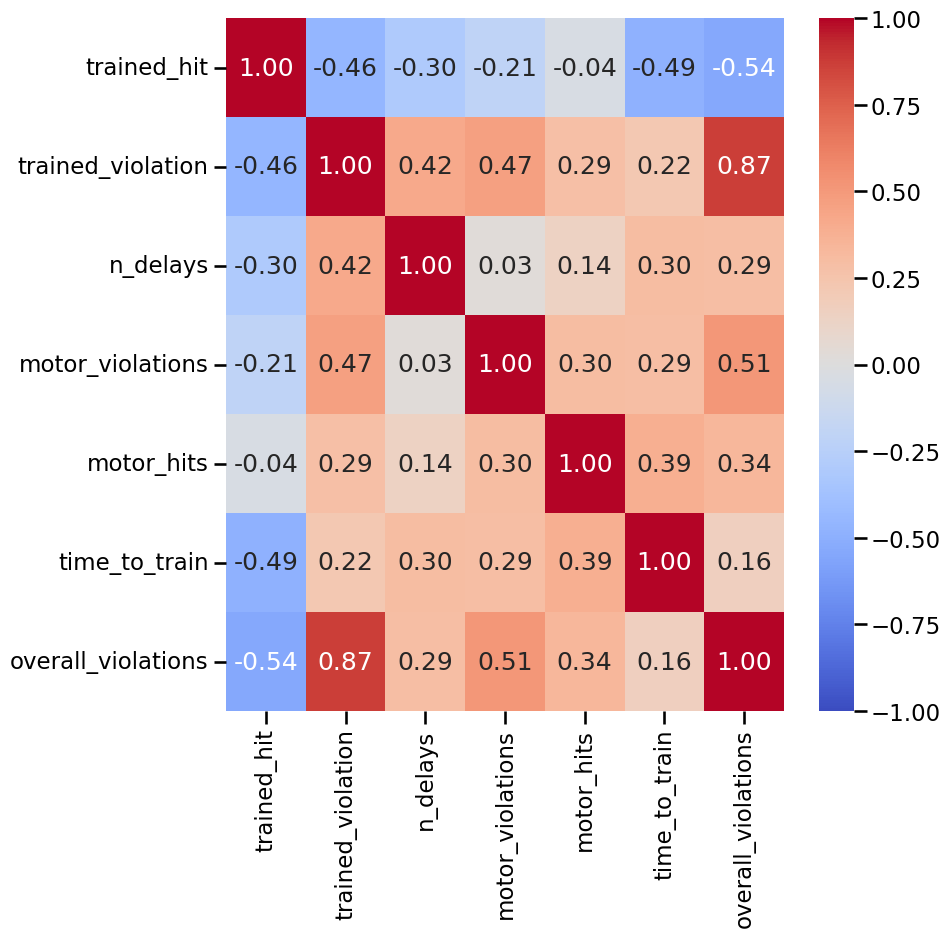

In [23]:
data_corr = data.query("animal_id != 'W082'").drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

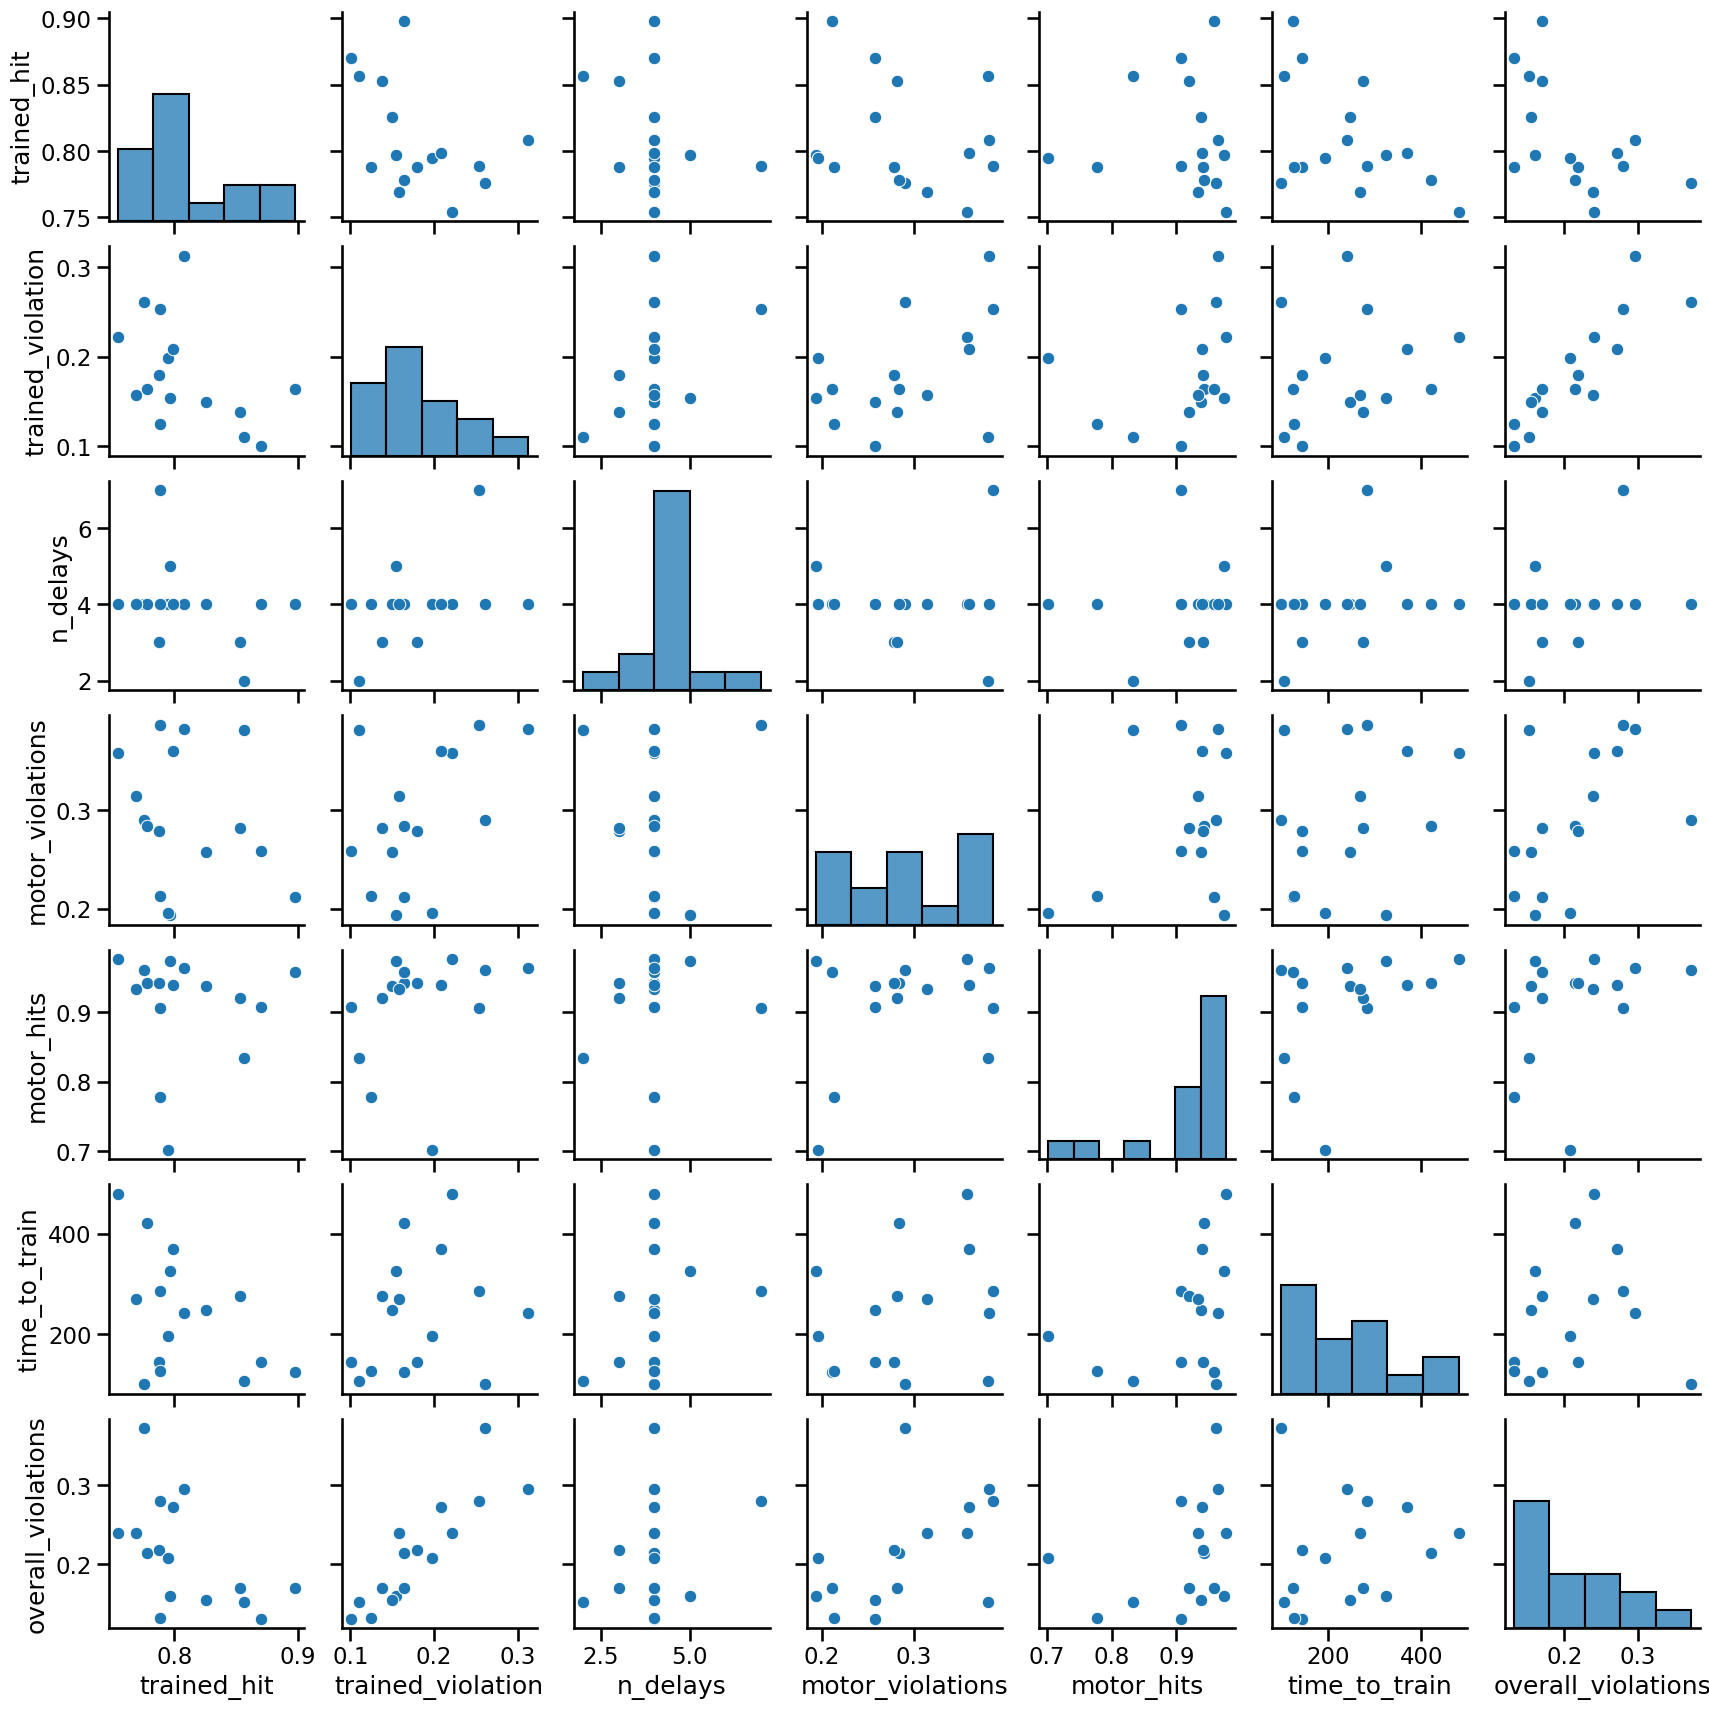

In [24]:
sns.pairplot(data.query("animal_id != 'W082'"))

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


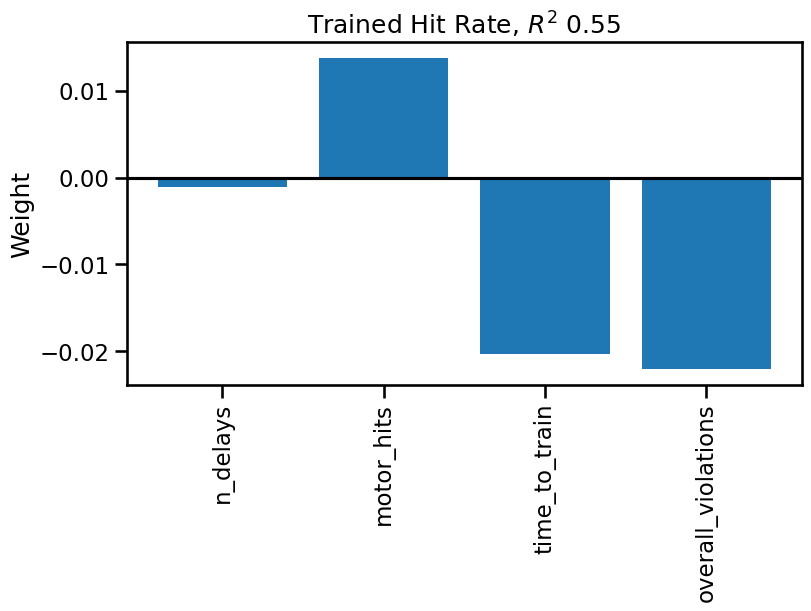

In [27]:
features = [
    column
    for column in data.columns.tolist()
    if column
    not in ["animal_id", "trained_hit", "motor_violations", "trained_violation"]
]

predictor = "trained_hit"

model, predict, rsq, rns, ws = fit_linear_model(
    data.query("animal_id != 'W082'"), predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
plot_weights(ax, rns, ws, f"Trained Hit Rate, $R^2$ {rsq:.2f}")
# plt.ylim(-0.05, 0.05)

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


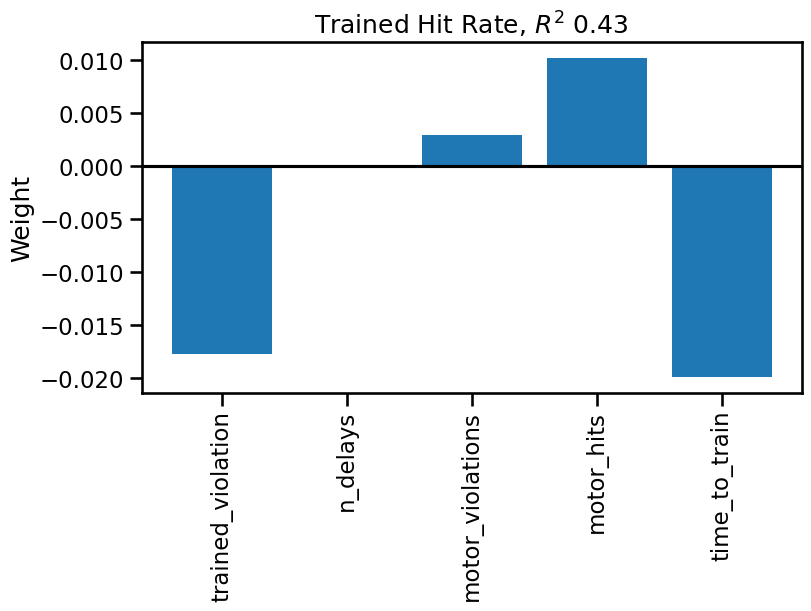

In [29]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_hit", "overall_violations"]
]

predictor = "trained_hit"

model, predict, rsq, rns, ws = fit_linear_model(
    data.query("animal_id != 'W082'"), predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
plot_weights(ax, rns, ws, f"Trained Hit Rate, $R^2$ {rsq:.2f}")
# plt.ylim(-0.05, 0.05)

These plots are all a bit messy- perhaps a random forest or decision tree would be better long term since these variables seem to be highly correlated. Including W082 in ttt leads to confusing results, while this animal leads to what would be expected for predicted hit rate. Will need to think about this much further. Because n delays, rigs are highly correlated with time to train- do they even belong here? 

For now, the most important thing is to save out the data for further analyses down the line.

If revisiting this- work on a correlation plot and remove correlated variables (e.g. stage 3 and stage 4 violation rate)